In [1]:
import numpy as np
import pandas as pd
import utils
from nn import NeuralNetwork
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
def evaluate_classification_metrics(y_true, y_pred, multiclass=False):

    average_type = 'macro' if multiclass else 'binary'

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average_type, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average_type, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average_type, zero_division=0)

    print(f"✅ Accuracy : {acc:.4f}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall   : {rec:.4f}")
    print(f"✅ F1 Score : {f1:.4f}")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }


In [3]:
# Load the dat
train_data = pd.read_csv(
    'data/loan-10k.lrn.csv'
)

train_data.head()


,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
0,24341,12500.0,12500.0,12500.0,36 months,7.21,387.17,< 1 year,MORTGAGE,81000.0,...,N,6,2018,6,2000,2,2019,2,2019,A
1,67534,33850.0,33850.0,33775.0,60 months,20.99,915.57,1 year,MORTGAGE,80000.0,...,N,10,2015,9,1984,2,2019,2,2019,E
2,35080,10000.0,10000.0,10000.0,60 months,20.00,264.94,< 1 year,RENT,36580.0,...,N,9,2017,10,2006,1,2018,11,2018,D
3,4828,20250.0,20250.0,20250.0,36 months,14.31,695.15,9 years,RENT,48700.0,...,N,0,2015,6,1996,6,2016,9,2017,C
4,59259,25000.0,25000.0,25000.0,36 months,14.99,866.52,1 year,MORTGAGE,85000.0,...,N,11,2016,0,2002,2,2019,2,2019,C


In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# 1. Separate features and target
X = train_data.drop(columns=["ID", "grade"])
y = train_data["grade"]

# 2. Label encode target (A, B, C → 0, 1, 2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3. One-hot encode target for softmax
ohe_y = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
y_onehot = ohe_y.fit_transform(y_encoded.reshape(-1, 1))

# 4. Identify feature types
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [col for col in X.columns if col not in cat_cols]

# 5. Preprocess features: One-hot categorical + scale numeric
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

X_processed = preprocessor.fit_transform(X)

# 6. Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y_onehot, test_size=0.2, random_state=42
)


In [5]:
configs = [
    # Simple
    {"layers": [X_train.shape[1],y_train.shape[1]], "act": [utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], y_train.shape[1]], "act": [utils.softmax], "lr": 0.1},

    # 1 hidden layer
    {"layers": [X_train.shape[1], 16, y_train.shape[1]], "act": [utils.relu, utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], 16, y_train.shape[1]], "act": [utils.tanh, utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], 16, y_train.shape[1]], "act": [utils.relu, utils.softmax], "lr": 0.1},
    {"layers": [X_train.shape[1], 16, y_train.shape[1]], "act": [utils.tanh, utils.softmax], "lr": 0.1},

    # 2 hidden layers
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.relu, utils.relu, utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.tanh, utils.relu, utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.tanh, utils.tanh, utils.softmax], "lr": 0.01},
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.relu, utils.relu, utils.softmax], "lr": 0.1},
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.tanh, utils.relu, utils.softmax], "lr": 0.1},
    {"layers": [X_train.shape[1], 16, 8, y_train.shape[1]], "act": [utils.tanh, utils.tanh, utils.softmax], "lr":0.1}]


In [6]:
results = []

for i, cfg in enumerate(configs):
    print(f"\n🔁 Running config {i+1}/{len(configs)}")
    print(f"Layers: {cfg['layers']}, Activations: {[fn.__name__ for fn in cfg['act']]}, LR: {cfg['lr']}")

    nn = NeuralNetwork(cfg["layers"], cfg["act"], learning_rate=cfg["lr"],multiclass=True)
    
    # Train including validation set
    nn.train(X_train, y_train, epochs=100, X_val=X_val, y_val=y_val)
    
    # Predict final output
    preds = nn.predict(X_val)  # output: class labels
    y_val_labels = np.argmax(y_val, axis=1)  # one-hot → class index

    metrics = evaluate_classification_metrics(y_val_labels, preds, multiclass=True)

    
    # Get metrics stored during training from the model
    train_loss = nn.history["train_loss"][-1]
    val_loss = nn.history["val_loss"][-1] if nn.history["val_loss"] else None
    train_acc = nn.history["train_acc"][-1]
    val_acc = nn.history["val_acc"][-1] if nn.history["val_acc"] else None

    total_params, total_bytes = nn.model_size(verbose=False)



    results.append({
        "config_id": i + 1,
        "layers": cfg["layers"],
        "activations": [fn.__name__ for fn in cfg["act"]],
        "learning_rate": cfg["lr"],

        # Add train history
        "train_loss": float(train_loss),
        "val_loss": float(val_loss) if val_loss is not None else None,
        "train_acc": float(train_acc),
        "val_acc": float(val_acc) if val_acc is not None else None,
        
        **metrics,

        "num_parameters": total_params,
        "ram_bytes": total_bytes,
        })




🔁 Running config 1/12
Layers: [179, 7], Activations: ['softmax'], LR: 0.01
Epoch 1/100, Loss: 2.7719, Acc: 0.4410, Val Loss: 1.3325, Val Acc: 0.5595
Epoch 2/100, Loss: 1.0927, Acc: 0.6150, Val Loss: 0.9767, Val Acc: 0.6570
Epoch 3/100, Loss: 0.8299, Acc: 0.6911, Val Loss: 0.8356, Val Acc: 0.6945
Epoch 4/100, Loss: 0.7002, Acc: 0.7322, Val Loss: 0.7596, Val Acc: 0.7160
Epoch 5/100, Loss: 0.6207, Acc: 0.7618, Val Loss: 0.7036, Val Acc: 0.7405
Epoch 6/100, Loss: 0.5696, Acc: 0.7806, Val Loss: 0.6666, Val Acc: 0.7560
Epoch 7/100, Loss: 0.5298, Acc: 0.7934, Val Loss: 0.6329, Val Acc: 0.7615
Epoch 8/100, Loss: 0.5033, Acc: 0.8064, Val Loss: 0.6145, Val Acc: 0.7655
Epoch 9/100, Loss: 0.4787, Acc: 0.8113, Val Loss: 0.5908, Val Acc: 0.7755
Epoch 10/100, Loss: 0.4627, Acc: 0.8225, Val Loss: 0.5791, Val Acc: 0.7760
Epoch 11/100, Loss: 0.4412, Acc: 0.8264, Val Loss: 0.5625, Val Acc: 0.7825
Epoch 12/100, Loss: 0.4333, Acc: 0.8326, Val Loss: 0.5536, Val Acc: 0.7820
Epoch 13/100, Loss: 0.4203, Acc: 

In [7]:
df_results = pd.DataFrame(results)
df_results

,config_id,layers,activations,learning_rate,train_loss,val_loss,train_acc,val_acc,accuracy,precision,recall,f1_score,num_parameters,ram_bytes
0,1,"[179, 7]",[softmax],0.01,0.269730,0.422899,0.894625,0.8445,0.8445,0.727800,0.721949,0.721706,1260,10080
1,2,"[179, 7]",[softmax],0.10,1.099926,1.650438,0.853375,0.8230,0.8230,0.705236,0.705238,0.690010,1260,10080
2,3,"[179, 16, 7]","[relu, softmax]",0.01,0.221194,0.629228,0.925750,0.8560,0.8560,0.753077,0.752149,0.750476,2999,23992
3,4,"[179, 16, 7]","[tanh, softmax]",0.01,0.212968,0.616858,0.922500,0.8005,0.8005,0.581837,0.592580,0.586434,2999,23992
4,5,"[179, 16, 7]","[relu, softmax]",0.10,1.594252,1.645673,0.294625,0.2940,0.2940,0.105219,0.144548,0.070046,2999,23992
5,6,"[179, 16, 7]","[tanh, softmax]",0.10,0.370884,0.665556,0.863750,0.7835,0.7835,0.603381,0.636405,0.602330,2999,23992
6,7,"[179, 16, 8, 7]","[relu, relu, softmax]",0.01,0.221579,0.501079,0.915375,0.8585,0.8585,0.682270,0.688759,0.681594,3079,24632
7,8,"[179, 16, 8, 7]","[tanh, relu, softmax]",0.01,0.284616,0.880772,0.889625,0.7420,0.7420,0.559182,0.570613,0.560749,3079,24632
8,9,"[179, 16, 8, 7]","[tanh, tanh, softmax]",0.01,0.285620,0.736732,0.891250,0.7630,0.7630,0.517945,0.543630,0.529425,3079,24632
9,10,"[179, 16, 8, 7]","[relu, relu, softmax]",0.10,1.602039,1.608216,0.292000,0.2935,0.2935,0.041929,0.142857,0.064830,3079,24632


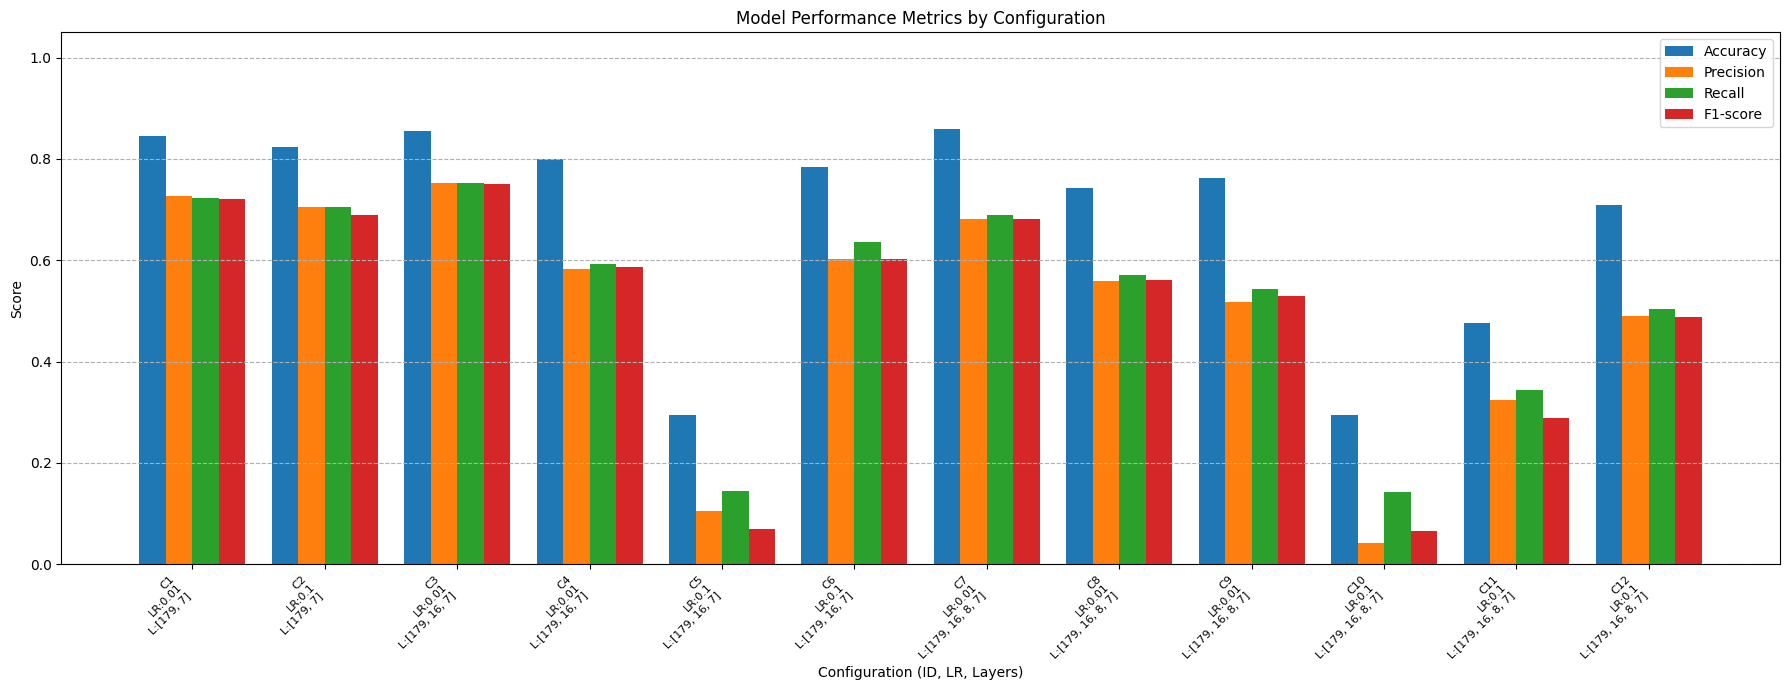

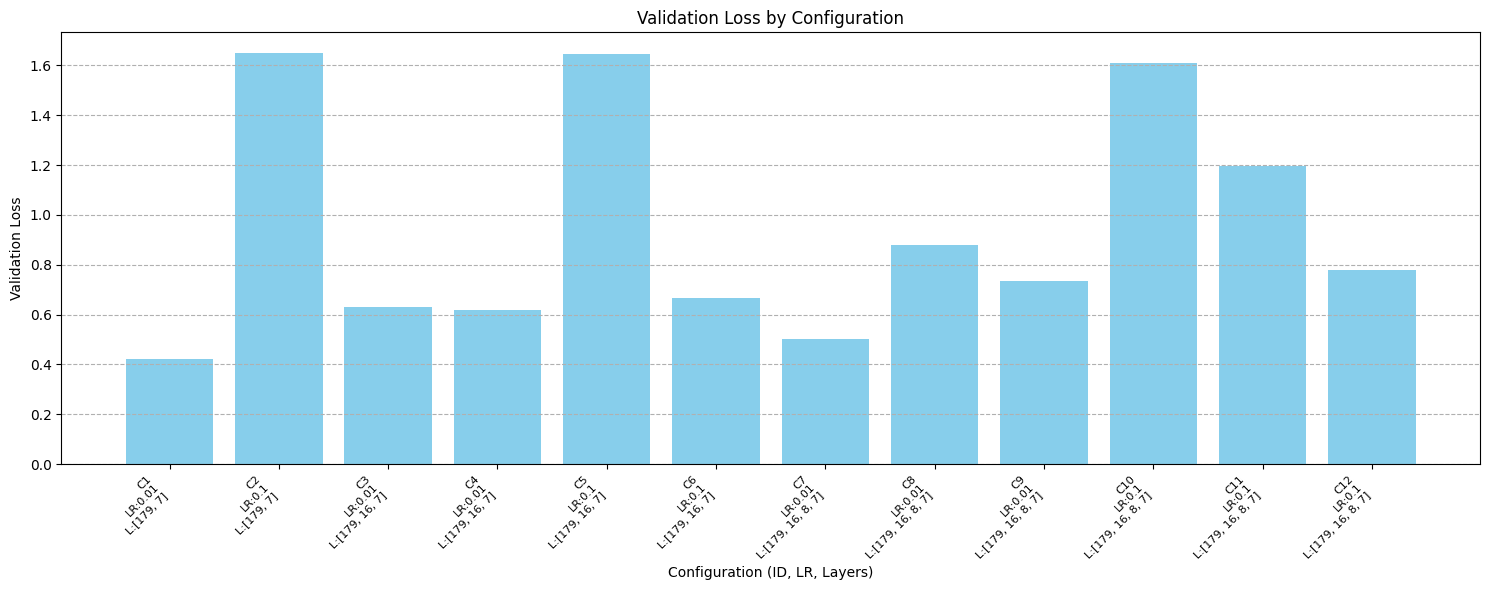

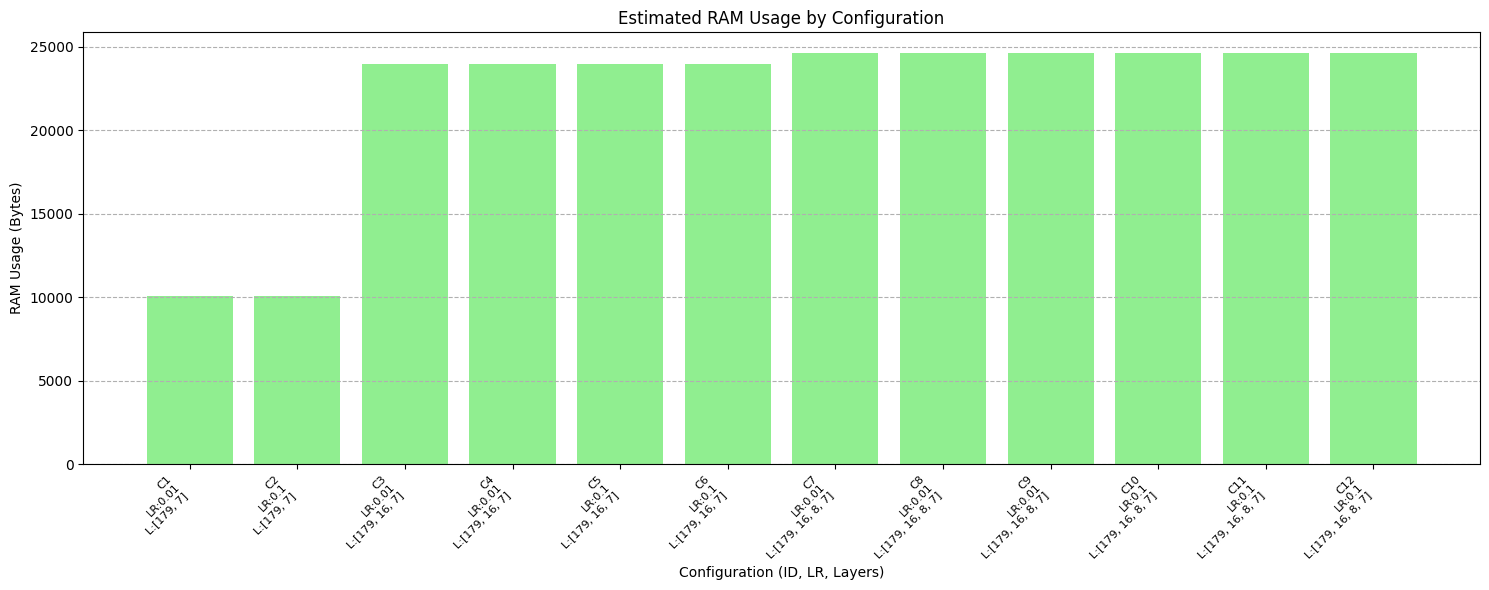

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Use your own DataFrame
results_df = df_results.copy()

# Add configuration labels for X-axis
results_df['config_label'] = results_df.apply(
    lambda row: f"C{row['config_id']}\nLR:{row['learning_rate']}\nL:{row['layers']}", axis=1
)

x_labels = results_df['config_label']
x_pos = np.arange(len(x_labels))

# --- Plot 1: Performance Metrics (Accuracy, Precision, Recall, F1-score) ---
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']

num_metrics = len(metrics_to_plot)
bar_width = 0.8 / num_metrics

plt.figure(figsize=(18, 7))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x_pos + i * bar_width - (bar_width * (num_metrics - 1) / 2),
            results_df[metric],
            width=bar_width,
            label=metric_names[i])

plt.xlabel("Configuration (ID, LR, Layers)")
plt.ylabel("Score")
plt.title("Model Performance Metrics by Configuration")
plt.xticks(x_pos, x_labels, rotation=45, ha="right", fontsize=8)
plt.legend()
plt.grid(True, axis='y', linestyle='--')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

# --- Plot 2: Validation Loss ---
plt.figure(figsize=(15, 6))
plt.bar(x_labels, results_df['val_loss'], color='skyblue')
plt.xlabel("Configuration (ID, LR, Layers)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss by Configuration")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.grid(True, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# --- Plot 3: RAM Usage ---
if 'ram_bytes' in results_df.columns:
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels, results_df['ram_bytes'], color='lightgreen')
    plt.xlabel("Configuration (ID, LR, Layers)")
    plt.ylabel("RAM Usage (Bytes)")
    plt.title("Estimated RAM Usage by Configuration")
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.grid(True, axis='y', linestyle='--')
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No 'ram_bytes' column in results — skipping RAM plot.")
